In [ ]:
!pip install pystan==2.19.1.1 prophet

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
from prophet import Prophet
#from hyperopt import fmin, tpe, hp, Trials, rand

In [2]:
google_stock_df = pd.read_csv('data/google-stock-dataset-Daily.csv', index_col=False)
google_stock_df = google_stock_df.drop(columns=['Unnamed: 0'])

In [3]:
google_stock_df.rename(columns={'Date': 'ds', 'Adj Close': 'y'}, inplace=True)

In [4]:
google_stock_df

,ds,Price,High,Low,Close,Volume,y
0,2013-04-15,19.67,19.94,19.44,19.57,98025876,19.57
1,2013-04-16,19.68,19.92,19.62,19.85,69610320,19.85
2,2013-04-17,19.69,19.79,19.47,19.58,81398520,19.58
3,2013-04-18,19.65,19.66,19.05,19.17,132767100,19.17
4,2013-04-19,19.25,20.11,19.18,20.02,231895872,20.02
...,...,...,...,...,...,...,...
2505,2023-03-27,104.62,104.76,101.93,102.46,31120900,102.46
2506,2023-03-28,102.44,102.45,99.74,101.03,32057900,101.03
2507,2023-03-29,102.28,102.49,100.65,101.39,28779600,101.39
2508,2023-03-30,100.91,101.16,99.78,100.89,33086200,100.89


In [5]:

# Define the percentage of data for training (e.g., 80%)
train_percentage = 0.8

# Calculate the number of rows for training and testing
total_rows = len(google_stock_df)
train_rows = int(train_percentage * total_rows)
test_rows = total_rows - train_rows

# Split the dataset into training and testing sets
train_data = google_stock_df.iloc[:train_rows]
test_data = google_stock_df.iloc[train_rows:]

In [6]:
len(train_data)

2008

In [7]:
len(test_data)
type(test_data)

pandas.core.frame.DataFrame

In [8]:
comparison_df = test_data.copy()

In [9]:
comparison_df = comparison_df.drop(columns=['Price', 'High', 'Low', 'Close', 'Volume'])

In [10]:
comparison_df.rename(columns={'ds': 'Date', 'y': 'Actual Price'}, inplace=True)

In [11]:
comparison_df

,Date,Actual Price
2008,2021-04-06,110.46
2009,2021-04-07,111.95
2010,2021-04-08,112.52
2011,2021-04-09,113.53
2012,2021-04-12,112.23
...,...,...
2505,2023-03-27,102.46
2506,2023-03-28,101.03
2507,2023-03-29,101.39
2508,2023-03-30,100.89


In [12]:
# Specify weekends as holidays
weekend_holidays = pd.DataFrame({
  'holiday': 'weekend',
  'ds': pd.date_range(start='2021-04-06', end='2023-03-31', freq='W-SAT')  # Generate a range of Saturdays
})


In [13]:
# Initialize the Prophet Model
model_prophet = Prophet()
model_prophet.add_country_holidays(country_name='US')
model_prophet.fit(train_data)

# Create a dataframe for future predictions
future = model_prophet.make_future_dataframe(periods=502)  # Predict for one year into the future

# Make predictions
forecast = model_prophet.predict(future)

12:32:35 - cmdstanpy - INFO - Chain [1] start processing
12:32:35 - cmdstanpy - INFO - Chain [1] done processing


In [14]:
predicted_value = forecast['yhat'].tail(502)
predicted_value_df = predicted_value.to_frame()

In [15]:
comparison_df['Predicted Price'] = predicted_value_df

In [17]:
def evaluate(predictions):
    print("MSE",round(mean_squared_error(predictions['Actual Price'], predictions['Predicted Price']), 3))
    print("RMSE",round(np.sqrt(mean_squared_error(predictions['Actual Price'], predictions['Predicted Price'])), 3))
    print("MAE",round(mean_absolute_error(predictions['Actual Price'], predictions['Predicted Price']), 3))

In [18]:
evaluate(comparison_df)

MSE 737.017
RMSE 27.148
MAE 24.207


In [24]:

comparison_df = comparison_df.reset_index(drop=True)

In [25]:
comparison_df

,Date,Actual Price,Predicted Price
0,2021-04-06,110.46,93.324397
1,2021-04-07,111.95,93.385392
2,2021-04-08,112.52,93.420315
3,2021-04-09,113.53,93.416800
4,2021-04-12,112.23,92.533140
...,...,...,...
497,2023-03-27,102.46,127.222553
498,2023-03-28,101.03,127.332245
499,2023-03-29,101.39,127.416820
500,2023-03-30,100.89,127.462796


#Test-Train Split
We are using sliding window for splitting the train-test dataset

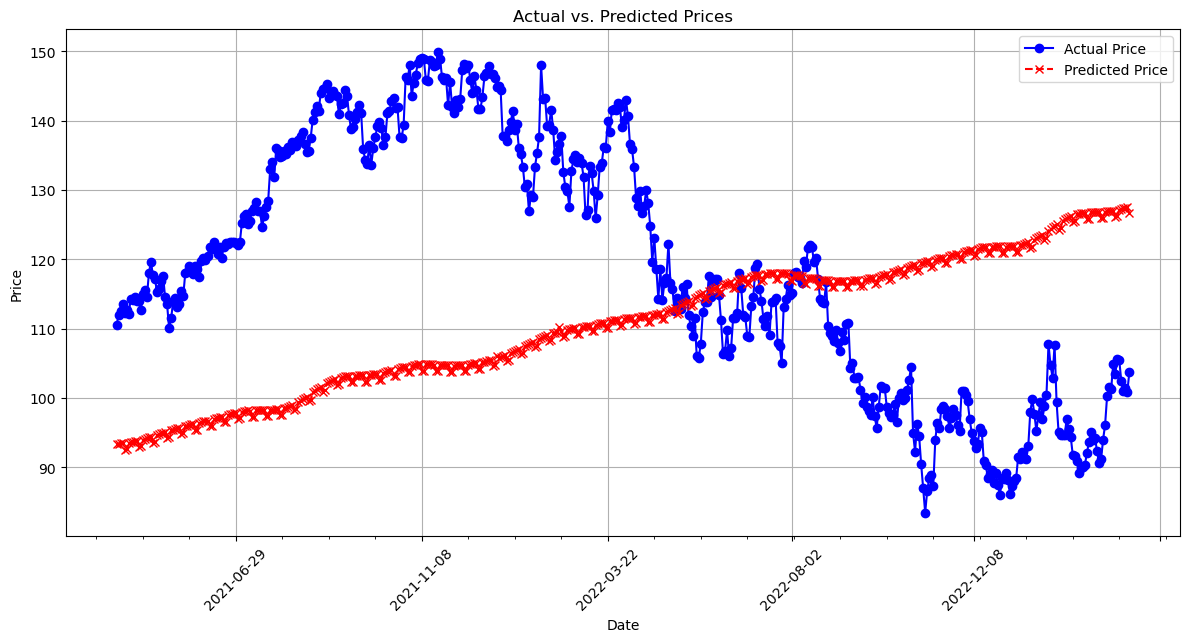

In [22]:
import matplotlib.pyplot as plt
from matplotlib.dates import MonthLocator
from matplotlib.ticker import AutoMinorLocator
from pandas.plotting import register_matplotlib_converters

# Assuming 'prediction_df' is your DataFrame with columns 'Date', 'Actual Price', and 'Predicted Price'

# Ensure proper date conversion for plotting
register_matplotlib_converters()

# Create a line graph
plt.figure(figsize=(12, 6))
plt.plot(comparison_df['Date'], comparison_df['Actual Price'], label='Actual Price', marker='o', linestyle='-', color='blue')
plt.plot(comparison_df['Date'], comparison_df['Predicted Price'], label='Predicted Price', marker='x', linestyle='--', color='red')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Actual vs. Predicted Prices')
plt.legend()
plt.grid(True)
plt.tight_layout()

# Set the major tick locator to display dates at 3-month intervals
ax = plt.gca()
ax.xaxis.set_major_locator(MonthLocator(interval=3))

# Set minor tick locator for better date visibility
ax.xaxis.set_minor_locator(AutoMinorLocator())

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show the graph (you can also save it as an image using plt.savefig)
plt.show()


In [ ]:
def create_feature_target(df, window_size):

    # Initialize empty lists to store the features (X) and target variable (y)
    features = []
    targets = []

    # Iterate over the dataframe to create the feature matrix X and target variable y
    for i in range(window_size, len(df)-1):
        # Extract the window of data for features
        window_data = df.iloc[i-window_size:i, 1:]
        window_data.drop('Price', axis=1)

        # Flatten the window data into a 1-dimensional vector
        flattened_window = window_data.values.flatten()

        # Append the flattened window to the features list
        features.append(flattened_window)

        # Get the target value (Price) for the next day and append it to the target variable list
        next_day_price = df.iloc[i+1, 1]
        targets.append(next_day_price)

    print(window_data)
    features = pd.DataFrame(features)
    targets = pd.DataFrame(targets, columns=["Price"])
    return features, targets


In [ ]:
def predicted_price(model, df, window_size):

    # Define the rolling window size and step
    window_size = 365  # Number of days in each window
    step_size = 30     # Number of days to step forward in each iteration

    # Initialize lists to store forecasts and actual values
    forecasts = []
    actuals = []

    # Perform rolling window forecasting
    for i in range(0, len(data) - window_size, step_size):
        window_data = data.iloc[i:i + window_size]

        # Initialize and fit the Prophet model for the window
        model = Prophet()
        model.fit(window_data)

        # Create a dataframe for future predictions within the window
        future = model.make_future_dataframe(periods=365)  # Predict for one year into the future

        # Make predictions for the window
        forecast = model.predict(future)

        # Append the forecast and actual values
        forecasts.append(forecast)
        actuals.append(window_data)

    # Concatenate forecasts and actuals into a single DataFrame
    all_forecasts = pd.concat(forecasts)
    all_actuals = pd.concat(actuals)


#Prediction Results without feature Extraction

In [ ]:
# Initialize the Prophet Model
model_prophet = Prophet()

# Define the window size (number of previous days to consider for prediction)
window_size = 7

predictions_xgb = predicted_price(model_prophet, google_stock_df_modelling, window_size)


In [ ]:
predictions_xgb

In [ ]:
evaluate(predictions_xgb)

#Prediction Results with feature Extraction

In [ ]:
def predicted_price_with_feature_extraction(model, df, window_size):

    feature_x, target_y = create_feature_target_extraction(df, window_size)
    # Split the data into training and testing sets
    x_train, x_test, y_train, y_test = train_test_split(feature_x, target_y, test_size=0.2, shuffle=False)

    model.fit(x_train, y_train)
    # Make predictions on the test data
    y_pred = model.predict(x_test)

    # Reshape y_pred to be 1-dimensional
    y_pred = y_pred.flatten()

    # Reset the index of y_test to match the indices of date_subset
    y_test_reset_index = y_test.reset_index(drop=True)

    # Create a subset of df["Date"] with matching indices
    date_subset = df["Date"].iloc[window_size + len(x_train) + 1: window_size + len(x_train) + len(y_pred) + 1].reset_index(drop=True)

    # Convert the predictions, y_test_reset_index, and date_subset to a pandas DataFrme
    predictions_df = pd.DataFrame({"Date": date_subset, "Actual Price": y_test_reset_index.values.flatten(), "Predicted Price": y_pred})
    return predictions_df


In [ ]:
def create_feature_target_extraction(df, window_size):
    # Initialize empty lists to store the features (X) and target variable (y)
    features = []
    targets = []

    # Calculate the moving average over the window size
    moving_average = df['Close'].rolling(window=window_size).mean()

    # Iterate over the dataframe to create the feature matrix X and target variable y
    for i in range(window_size, len(df) - 1):
        # Extract the window of data for features
        window_data = df.iloc[i - window_size:i, :]

        # Calculate the moving average feature for the window
        ma_feature = moving_average.iloc[i - window_size]

        # Filter out non-numeric columns
        numeric_cols = window_data.select_dtypes(include=[np.number]).columns

        # Flatten the numeric columns of the window data into a 1-dimensional vector
        flattened_window = window_data[numeric_cols].values.flatten()

        # Append the flattened window and moving average feature to the features list
        features.append(np.concatenate((flattened_window, [ma_feature])))

        # Get the target value (Price) for the next day and append it to the target variable list
        next_day_price = df.iloc[i + 1, 1] 
        targets.append(next_day_price)

    features = pd.DataFrame(features)
    targets = pd.DataFrame(targets, columns=["Price"])
    return features, targets



In [ ]:
# Define the parameter values
params = {
    'colsample_bytree': 0.9172716609311327,
    'learning_rate': 0.6253240010667009,
    'max_depth': 8,
    'n_estimators': 70,
    'subsample': 0.9605703978539917
}

# Initialize the XGBoost regressor with the specified parameters
model_xgb_feature_extracted = xgb.XGBRegressor(**params)
predictions_xgb_with_extraction = predicted_price_with_feature_extraction(model_xgb, google_stock_df_modelling, window_size)

In [ ]:
predictions_xgb_with_extraction

In [ ]:
evaluate(predictions_xgb_with_extraction)

In [ ]:
feature_x, target_y = create_feature_target_extraction(google_stock_df_modelling, 7)
train_features, test_features, train_target, test_target = train_test_split(feature_x, target_y, test_size=0.2, shuffle=False)

In [ ]:
train_features

#Hyperopt

In [ ]:
def XGBoostFunc(params):
    # Set the hyperparameters
    max_depth = params['max_depth']
    learning_rate = params['learning_rate']
    n_estimators = params['n_estimators']
    subsample = params['subsample']
    colsample_bytree = params['colsample_bytree']
    
    model_XGBOOST = xgb.XGBRegressor(max_depth=max_depth,
                             learning_rate=learning_rate,
                             n_estimators=n_estimators,
                             subsample=subsample,
                             colsample_bytree=colsample_bytree)
    model_XGBOOST.fit(train_features, train_target)
    predicted_values_XGBOOST = model_XGBOOST.predict(test_features)
    loss = mean_squared_error(test_target,predicted_values_XGBOOST)
    return loss


#Space Definition

The search space for the hyperparameters! The search space refers to the range or set of possible values that each hyperparameter can take during the optimization process.

n_estimators -> no. of estimators(individual decision tree that contributes to the final prediction)

subsample -> subsample represents the range or distribution of values that we want to explore during the optimization process. Choosing a lower value of subsample (e.g., closer to 0.5) means that each tree will be trained on a smaller subset of the training data, introducing more randomness and reducing overfitting. Selecting a higher value of subsample (e.g., closer to 1) means that each tree will use a larger fraction of the training data, with a higher risk of overfitting.

colsample_bytree -> controls the subset of features that are used to build each individual tree.

In [ ]:
space = {
    'max_depth': hp.choice('max_depth', range(1, 10)),
    'learning_rate': hp.loguniform('learning_rate', -5, 0),
    'n_estimators': hp.choice('n_estimators', range(50, 200)),
    'subsample': hp.uniform('subsample', 0.5, 1),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1),
}

In [ ]:
# Configure Hyperopt
trials = Trials()
max_evals = 50 

In [ ]:
best = fmin(
    fn=XGBoostFunc,
    space=space,
    algo=tpe.suggest,
    trials=trials,
    max_evals=max_evals
)

In [ ]:
best

In [ ]:
# Define the parameter values
params = {
    ''colsample_bytree': 0.9172716609311327,
    'learning_rate': 0.6253240010667009,
    'max_depth': 8,
    'n_estimators': 70,
    'subsample': 0.9605703978539917
}

# Initialize the XGBoost regressor with the specified parameters
model_xgb_opt = xgb.XGBRegressor(**params)

# Define the window size (number of previous days to consider for prediction)
window_size = 7

predictions_xgb_opt = predicted_price_with_feature_extraction(model_xgb_opt, google_stock_df_modelling, window_size)

In [ ]:
predictions_xgb_opt

In [ ]:
evaluate(predictions_xgb_opt)

#Parallelizing Hyperopt Tuning

In [ ]:
from hyperopt import SparkTrials
import mlflow

#Spark Trials

SparkTrials takes 2 optional arguments:

parallelism: Number of models to fit and evaluate concurrently. The default is the number of available Spark task slots.

timeout: Maximum time (in seconds) that fmin() can run. The default is no maximum time limit.

#Types of search algo 
hyperopt.tpe.suggest: Tree of Parzen Estimators, a Bayesian approach which iteratively and adaptively selects new hyperparameter settings to explore based on past results
hyperopt.rand.suggest: Random search, a non-adaptive approach that samples over the search space

In [ ]:
spark_trials = SparkTrials(4)
max_evals_spark = 100

with mlflow.start_run():
  argmin = fmin(
    fn=XGBoostFunc,
    space=space,
    algo=rand.suggest,
    max_evals=max_evals_spark,
    trials=spark_trials)

In [ ]:
argmin

In [ ]:
# Define the parameter values
params = {
    'colsample_bytree': 0.6168136805920839,
    'learning_rate': 0.5388100199935252,
    'max_depth': 7,
    'n_estimators': 143,
    'subsample': 0.5878989107028276
}

# Initialize the XGBoost regressor with the specified parameters
model_xgb_opt = xgb.XGBRegressor(**params)

# Define the window size (number of previous days to consider for prediction)
window_size = 7

predictions_xgb_opt_spark_rand = predicted_price(model_xgb_opt, google_stock_df_modelling, window_size)
evaluate(predictions_xgb_opt_spark_rand)

In [ ]:
spark_trials = SparkTrials(4)
max_evals_spark = 100

with mlflow.start_run():
  argmin_tpe = fmin(
    fn=XGBoostFunc,
    space=space,
    algo=tpe.suggest,
    max_evals=max_evals_spark,
    trials=spark_trials)

In [ ]:
argmin_tpe

In [ ]:
# Define the parameter values
params = {
    'colsample_bytree': 0.7363397845367727,
    'learning_rate': 0.9791674584219473,
    'max_depth': 4,
    'n_estimators': 37,
    'subsample': 0.7066230640051272
}

# Initialize the XGBoost regressor with the specified parameters
model_xgb_opt = xgb.XGBRegressor(**params)

# Define the window size (number of previous days to consider for prediction)
window_size = 7

predictions_xgb_opt_spark_tpe = predicted_price(model_xgb_opt, google_stock_df_modelling, window_size)
evaluate(predictions_xgb_opt_spark_tpe)

In [ ]:
model_XGBFR = XGBRFRegressor()
model_XGBFR.fit(train_features, train_target)

In [ ]:
predicted_values_XGBFR = model_XGBFR.predict(test_features)

In [ ]:
print("MSE",round(mean_squared_error(test_target,predicted_values_XGBFR), 3))
print("RMSE",round(np.sqrt(mean_squared_error(test_target,predicted_values_XGBFR)), 3))
print("MAE",round(mean_absolute_error(test_target,predicted_values_XGBFR), 3))

In [ ]:
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'mse',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0
}

In [ ]:
train_data = lgb.Dataset(train_features, label=train_target)

In [ ]:
model_lightGBM = lgb.train(params, train_data, 100)
predicted_values_lightGBM = model_lightGBM.predict(test_features)

In [ ]:
print("MSE",round(mean_squared_error(test_target,predicted_values_lightGBM), 3))
print("RMSE",round(np.sqrt(mean_squared_error(test_target,predicted_values_lightGBM)), 3))
print("MAE",round(mean_absolute_error(test_target,predicted_values_lightGBM), 3))